In [70]:
import numpy
from PIL import Image
from os import listdir
def imagesList (folder):
    images=[]
    for filename in listdir(folder):
        img= Image.open(folder+filename).convert('RGB')
        img=numpy.array(img)               #
        images.append(img)               # Appending all images in 'images' list 
    return(images)

maps = imagesList("Map/")   
masks = imagesList("Masks/")

In [71]:
from skimage import exposure
import time
import matplotlib.pyplot as plt
def resizeImg (img):
    images_box=[]
    width, height, dim = img.shape
    chopsize = 256
    i=0
    for x0 in range(0, width-chopsize, chopsize):
        for y0 in range(0, height-chopsize, chopsize):
            img_crop = img[x0:(x0+chopsize),y0:(y0+chopsize),:]
            images_box.append(img_crop)
    return images_box

def equalizeHist(img):
    colors = ("g")
    channel_ids = (1)
    myCropImgMasks = numpy.asarray(exposure.equalize_hist(img[:, :, channel_ids]) * 255, dtype='uint8')
    return myCropImgMasks

def imgLabelize(img2,ind):
    width, height= img2.shape
    img = [[0 for i in range(width)] for j in range(height)] 
    for x0 in range(0, width):
        for y0 in range(0, height):  
            if img2[x0][y0] > ind:
                img[x0][y0] = 1
            else :
                img[x0][y0] = 0
    return img


myMasks = []
myInputMaps = []
for i in range (len(maps)):
    cropMasks = resizeImg(masks[i])
    cropMaps = resizeImg(maps[i])
    masksConstructor = []
    for j in range (len(cropMasks)):
        equalHistMasks = equalizeHist(cropMasks[j])
        labelizeMasks = imgLabelize(equalHistMasks,120)
        masksConstructor.append(labelizeMasks)
    print("DATABASE Progression : ", (i+1) / len(maps) * 100,"%")
    if(i == 0):
        myMasks = masksConstructor
        myInputMaps = cropMaps
        
    else :
        myMasks = numpy.vstack((myMasks, masksConstructor))
        myInputMaps = numpy.vstack((myInputMaps, cropMaps))
    
print(numpy.array(myMasks).shape)
print(numpy.array(myInputMaps).shape)
numpy.save('myMasks', numpy.array(myMasks))
numpy.save('myInputMaps', numpy.array(myInputMaps))

DATABASE Progression :  5.0 %
DATABASE Progression :  10.0 %
DATABASE Progression :  15.0 %
DATABASE Progression :  20.0 %
DATABASE Progression :  25.0 %
DATABASE Progression :  30.0 %
DATABASE Progression :  35.0 %
DATABASE Progression :  40.0 %
DATABASE Progression :  45.0 %
DATABASE Progression :  50.0 %
DATABASE Progression :  55.00000000000001 %
DATABASE Progression :  60.0 %
DATABASE Progression :  65.0 %
DATABASE Progression :  70.0 %
DATABASE Progression :  75.0 %
DATABASE Progression :  80.0 %
DATABASE Progression :  85.0 %
DATABASE Progression :  90.0 %
DATABASE Progression :  95.0 %
DATABASE Progression :  100.0 %
(6460, 256, 256)
(6460, 256, 256, 3)


In [ ]:
myMasks = numpy.load('myMasks.npy')
myInputMaps = numpy.load('myInputMaps.npy')
print(numpy.array(myMasks).shape)
print(numpy.array(myInputMaps).shape)
myMasks = myMasks[:500,:,:]
myInputMaps = myInputMaps[:500,:,:,:]
print(numpy.array(myMasks).shape)
print(numpy.array(myInputMaps).shape)

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *

def UNet(pretrained_weights = None,input_size = (256,256,3),num_classes=2):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(num_classes, 1, activation = 'softmax',padding='same')(conv9)

    model = Model(inputs, conv10)

    return model


X_train, X_test, y_train, y_test = train_test_split(myInputMaps, myMasks, 
                                                    train_size=0.6, 
                                              random_state=42)
print(numpy.array(X_train).shape)
print(numpy.array(X_test).shape)
print(numpy.array(y_train).shape)
print(numpy.array(y_test).shape)
model = UNet()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

(6460, 256, 256)
(6460, 256, 256, 3)
(500, 256, 256)
(500, 256, 256, 3)
(300, 256, 256, 3)
(200, 256, 256, 3)
(300, 256, 256)
(200, 256, 256)
Epoch 1/10


In [80]:
plt.imshow(myCropImgMaps[10])

NameError: name 'myCropImgMaps' is not defined

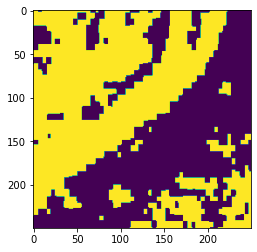

In [431]:

imgReturn = imgLabelize(myCropImgMasks,120)
plt.imshow(imgReturn)
